# This notebook processes ATL11 data into a format easy to compare with Alpine3D

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import glob

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# Get spatial bounds of Alpine3D

In [2]:
ds = xr.open_dataset("../data/A3D-2015-2020-daily-snd.nc")

In [3]:
# # Use Alpine3D bounds
# xmin = ds['easting'].min().values
# xmax = ds['easting'].max().values
# ymin = ds['northing'].min().values
# ymax = ds['northing'].max().values

# No bounds
xmin = -1e20
xmax = 1e20
ymin = -1e20
ymax = 1e20

# Functions to get ATL11 into NetCDF

In [4]:
def read_ATL11(path):
    '''
    Read ATL11 H5 binary file into numpy arrays. 
    ATL11 spec: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL11_ATBD_r004.pdf
    '''
    
    # Load file into memory 
    data = h5py.File(path, 'r')
    
    return data

def ATL11_to_NetCDF(path, pt_str):
    
    '''
    Convert ATL11 H5 binary file to Xarray data set. 
    
    To do: Collect data from all three pairs! 
    '''
    
    data = read_ATL11(path)
    
    da_hcorr = xr.DataArray(data[pt_str + '/h_corr'][:], coords={"lat": data[pt_str + '/latitude'][:], "cycle": np.arange(data[pt_str + '/h_corr'][:].shape[1]) + 1}, dims=("lat", "cycle"))
    da_hcorr = da_hcorr.assign_coords(lon=("lat", data[pt_str + '/longitude'][:]))

    da_hcorr_sigma = xr.DataArray(data[pt_str + '/h_corr_sigma'][:], coords={"lat": data[pt_str + '/latitude'][:], "cycle": np.arange(data[pt_str + '/h_corr'][:].shape[1]) + 1}, dims=("lat", "cycle"))
    da_hcorr_sigma = da_hcorr_sigma.assign_coords(lon=("lat", data[pt_str + '/longitude'][:]))

    da_hcorr_sigma_systematic = xr.DataArray(data[pt_str + '/h_corr_sigma_systematic'][:], coords={"lat": data[pt_str + '/latitude'][:], "cycle": np.arange(data[pt_str + '/h_corr'][:].shape[1]) + 1}, dims=("lat", "cycle"))
    da_hcorr_sigma_systematic = da_hcorr_sigma_systematic.assign_coords(lon=("lat", data[pt_str + '/longitude'][:]))
    
    da_time = xr.DataArray(data[pt_str + '/delta_time'][:], coords={"lat": data[pt_str + '/latitude'][:], "cycle": np.arange(data[pt_str + '/h_corr'][:].shape[1]) + 1}, dims=("lat", "cycle"))
    da_time = da_time.assign_coords(lon=("lat", data[pt_str + '/longitude'][:]))

    ds = xr.Dataset({"Height": da_hcorr})
    ds['Height_Sigma'] = da_hcorr_sigma
    ds['Height_Sigma_Systematic'] = da_hcorr_sigma_systematic
    ds['Time'] = da_time
    
    return ds

def qc_ATL11(path, pt_str):
    
    ds = ATL11_to_NetCDF(path, pt_str)
    ds['Height'] = ds['Height'].where(ds['Height'] < 1e10, np.nan)
    ds['Height'] = ds['Height'].where(ds['Height'] > 0, np.nan)
    ds['Height_Sigma'] = ds['Height_Sigma'].where(ds['Height_Sigma'] < 1e10, np.nan)
    ds['Height_Sigma'] = ds['Height_Sigma'].where(ds['Height_Sigma'] > 0, np.nan)
    ds['Height_Sigma_Systematic'] = ds['Height_Sigma_Systematic'].where(ds['Height_Sigma_Systematic'] < 1e10, np.nan)
    ds['Height_Sigma_Systematic'] = ds['Height_Sigma_Systematic'].where(ds['Height_Sigma_Systematic'] > 0, np.nan)
    ds['Time'] = ds['Time'].where(ds['Time'] < 1e10, np.nan)
    ds['Time'] = ds['Time'].where(ds['Time'] > 0, np.nan)
    
    return ds
    
def spatial_sample_ATL11(path, pt_str, xmin, xmax, ymin, ymax):
    
    '''
    Sets values outside spatial box to NaN
    
    1. Regrid lat/lon to x/y in epsg3031
    2. Set values outside of box to NaN 
    3. Assign x and y as coordinates
    
    '''
    
    # Load lat/lon
    ds = qc_ATL11(path, pt_str)
    lat = ds['lat'].values
    lon = ds['lon'].values
    
    # Convert lat/lon to x/y in epsg3031
    # Source and target EPSG
    src = osr.SpatialReference()
    tgt = osr.SpatialReference()
    src.ImportFromEPSG(4326) # WGS-84
    tgt.ImportFromEPSG(3031) # South Polar Stereo

    # Define transformation
    transform = osr.CoordinateTransformation(src, tgt)

    # Initialize arrays
    x = np.zeros(len(lon)); x[:] = np.nan
    y = np.zeros(len(lat)); y[:] = np.nan

    # Perform transformation
    for j in range(0, len(x)):
        coords = transform.TransformPoint(lat[j], lon[j]) # Lat, Lon
        x[j], y[j] = coords[0:2]
        
    # Set values outside of box to NaN!    
    x[x < xmin] = np.nan
    x[x > xmax] = np.nan
    y[np.argwhere(np.isnan(x))] = np.nan    

    y[y < ymin] = np.nan
    y[y > ymax] = np.nan
    x[np.argwhere(np.isnan(y))] = np.nan  
    
    ds['Height'][np.argwhere(np.isnan(x))[:,0],:] = np.nan
    ds['Height_Sigma'][np.argwhere(np.isnan(x))[:,0],:] = np.nan
    ds['Height_Sigma_Systematic'][np.argwhere(np.isnan(x))[:,0],:] = np.nan
    
    # Change lat/lon to x/y
    ds['lon'] = x
    ds['lat'] = y
    ds = ds.rename({'lat':'y', 'lon':'x'})

    return ds

def save_NetCDF(path, pt_str, xmin, xmax, ymin, ymax):
    
    ds = spatial_sample_ATL11(path, pt_str, xmin, xmax, ymin, ymax)
    
    tgt_path = "../data/" + pt_str + "_" + path.split("/")[-1][:-3] + ".nc"
    
    # Only save if there is non-nan data
    if np.count_nonzero(~np.isnan(ds['x'])) != 0:
        ds.to_netcdf(tgt_path, mode="w")
        print(tgt_path)

def loop_over_all_pair_tracks(path, xmin, xmax, ymin, ymax):
    
    pt_strings = ["pt1", "pt2", "pt3"]
    
    for j in range(0, len(pt_strings)):
        save_NetCDF(path, pt_strings[j], xmin, xmax, ymin, ymax)

# Application on one file

In [5]:
# Perform file processing
!rm ../data/pt*ATL11*.nc
src_path = "/scratch/summit/erke2265/ATL11/data/ATL11_042310_0309_003_01.h5"
loop_over_all_pair_tracks(src_path, xmin, xmax, ymin, ymax)

../data/pt1_ATL11_042310_0309_003_01.nc
../data/pt2_ATL11_042310_0309_003_01.nc
../data/pt3_ATL11_042310_0309_003_01.nc


In [6]:
# Open processed file
ds_ATL11 = xr.open_dataset("../data/pt1_ATL11_042310_0309_003_01.nc")
ds_ATL11

<xarray.Dataset>
Dimensions:                  (cycle: 7, x: 13177, y: 13177)
Coordinates:
  * y                        (y) float64 -1.698e+03 -1.71e+03 ... -9.622e+04
  * cycle                    (cycle) int64 1 2 3 4 5 6 7
  * x                        (x) float64 -1.969e+06 -1.968e+06 ... -1.194e+06
Data variables:
    Height                   (y, cycle) float32 ...
    Height_Sigma             (y, cycle) float32 ...
    Height_Sigma_Systematic  (y, cycle) float32 ...
    Time                     (y, cycle) float64 ...

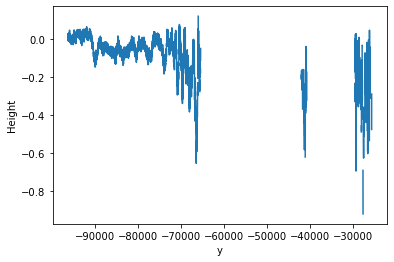

In [7]:
dh = ds_ATL11['Height'][:,4] - ds_ATL11['Height'][:,2]
dh.plot()

# Perform operation on several (or all) files

In [8]:
!rm ../data/pt*ATL11*.nc
src_dir = "/scratch/summit/erke2265/ATL11/data/*.h5"
src_files = glob.glob(src_dir)

# n_max_files = 5 # Test
n_max_files = len(src_files) # All files
print(n_max_files)

for j in range(0, n_max_files):
    print(j)
    loop_over_all_pair_tracks(src_files[j], xmin, xmax, ymin, ymax)

4151
0
../data/pt1_ATL11_087410_0309_003_01.nc
../data/pt2_ATL11_087410_0309_003_01.nc
../data/pt3_ATL11_087410_0309_003_01.nc
1
../data/pt1_ATL11_025911_0309_003_01.nc
../data/pt2_ATL11_025911_0309_003_01.nc
../data/pt3_ATL11_025911_0309_003_01.nc
2
../data/pt1_ATL11_106212_0309_003_01.nc
../data/pt2_ATL11_106212_0309_003_01.nc
../data/pt3_ATL11_106212_0309_003_01.nc
3
../data/pt1_ATL11_008011_0309_003_01.nc
../data/pt2_ATL11_008011_0309_003_01.nc
../data/pt3_ATL11_008011_0309_003_01.nc
4
../data/pt1_ATL11_091912_0309_003_01.nc
../data/pt2_ATL11_091912_0309_003_01.nc
../data/pt3_ATL11_091912_0309_003_01.nc
5
../data/pt1_ATL11_099712_0309_003_01.nc
../data/pt2_ATL11_099712_0309_003_01.nc
../data/pt3_ATL11_099712_0309_003_01.nc
6
../data/pt1_ATL11_102912_0309_003_01.nc
../data/pt2_ATL11_102912_0309_003_01.nc
../data/pt3_ATL11_102912_0309_003_01.nc
7
../data/pt1_ATL11_111112_0309_003_01.nc
../data/pt2_ATL11_111112_0309_003_01.nc
../data/pt3_ATL11_111112_0309_003_01.nc
8
../data/pt1_ATL11